In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



In [ ]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color='#1f77b4',
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [ ]:
cpi = pd.read_csv("/All items in U.S. city average, all urban consumers, not seasonally adjusted - BLS Data Series.csv",
parse_dates=['Year'])
cpi.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2012-01-01,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601
1,2013-01-01,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049
2,2014-01-01,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812
3,2015-01-01,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525
4,2016-01-01,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432


In [ ]:
cpi = cpi.set_index("Year").to_period('M')
cpi.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2012-01,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601
2013-01,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049
2014-01,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812
2015-01,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525
2016-01,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432


In [ ]:
ax = cpi.plot(**plot_params)
ax.set(title="Consumer Price Index ", ylabel="CPI Measure");

In [ ]:
trend = cpi.rolling(
        window=120,
        center=True,
        min_periods=60,
        ).mean()

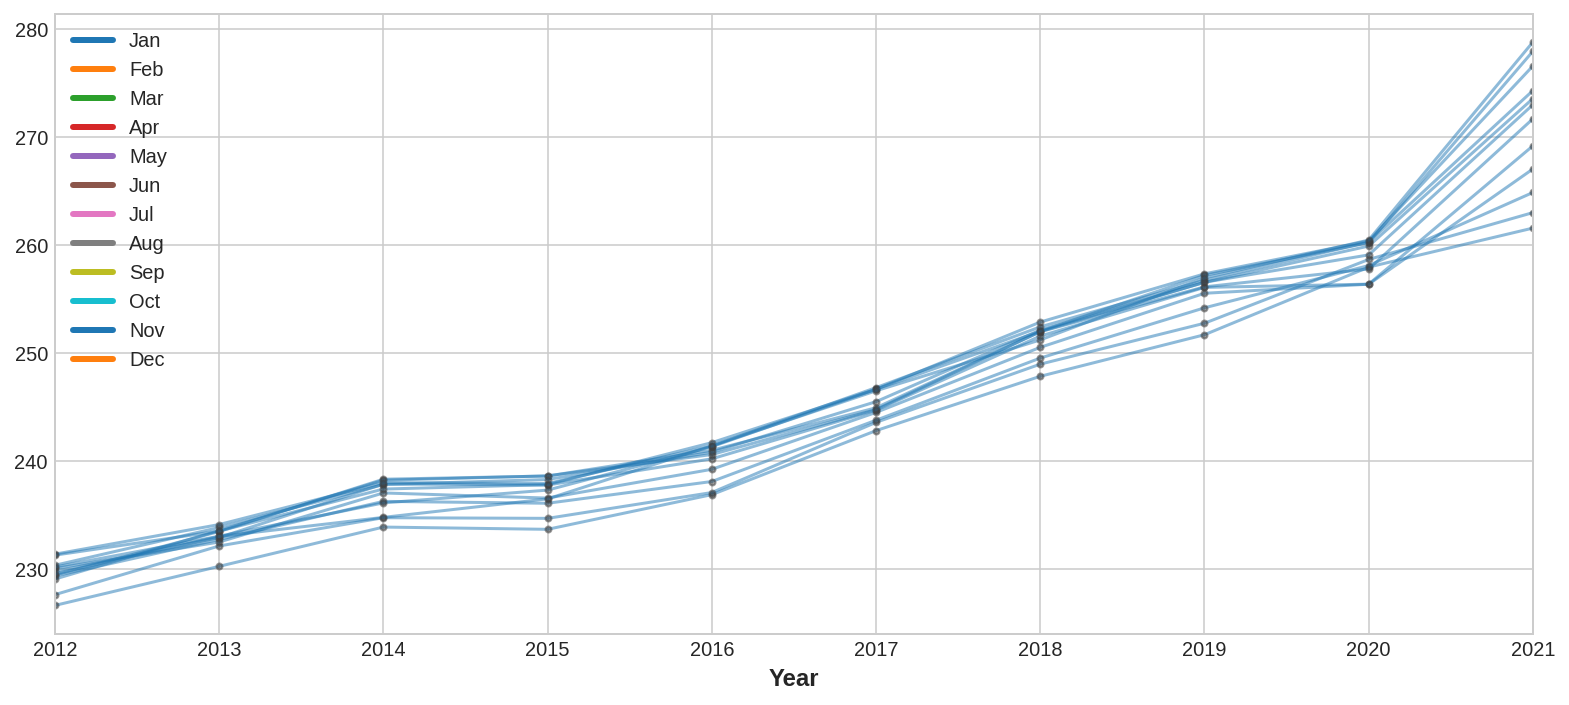

In [ ]:
ax = cpi.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [ ]:
#!pip install statsmodels==0.12.1

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = cpi.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
index=y.index,
order=3,
drop=True)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)
print(X_fore.head())


         trend  trend_squared  trend_cubed
2021-02   11.0          121.0       1331.0
2021-03   12.0          144.0       1728.0
2021-04   13.0          169.0       2197.0
2021-05   14.0          196.0       2744.0
2021-06   15.0          225.0       3375.0


In [ ]:
model = LinearRegression()
model.fit(X, y)
​
y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)
​
ax = y.plot(**plot_params, alpha=0.5, title="Consumer Price Index", ylabel="Year")
ax = y_pred.plot(ax=ax, linewidth=3, label="Consumer Price Index", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Consumer Price Index Forecast", color='C3')
ax.legend();

SyntaxError: ignored

In [ ]:
dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();


# Time Series Histogram

This example demonstrates how to efficiently visualize large numbers of time series in a way that could potentially reveal hidden substructure and patterns that are not immediately obvious, and display them in a visually appealing way.

In this example, we generate multiple sinusoidal "signal" series that are buried under a larger number of random walk "noise/background" series. For an unbiased Gaussian random walk with standard deviation of σ, the RMS deviation from the origin after n steps is σ*sqrt(n). So in order to keep the sinusoids visible on the same scale as the random walks, we scale the amplitude by the random walk RMS. In addition, we also introduce a small random offset phi to shift the sines left/right, and some additive random noise to shift individual data points up/down to make the signal a bit more "realistic" (you wouldn't expect a perfect sine wave to appear in your data).

The first plot shows the typical way of visualizing multiple time series by overlaying them on top of each other with plt.plot and a small value of alpha. The second and third plots show how to reinterpret the data as a 2d histogram, with optional interpolation between data points, by using np.histogram2d and plt.pcolormesh.

0.702 sec. elapsed
0.269 sec. elapsed


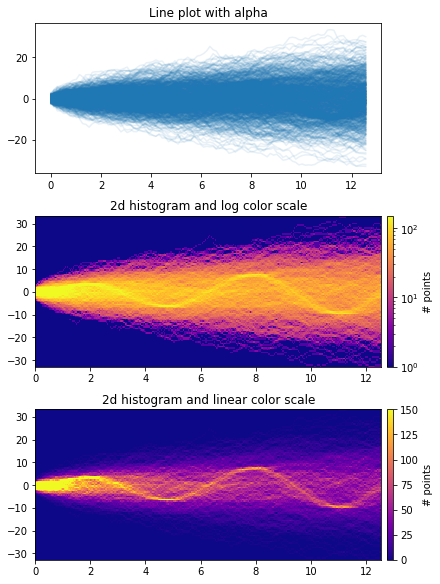

In [ ]:
from copy import copy
import time

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(nrows=3, figsize=(6, 8), constrained_layout=True)

# Make some data; a 1D random walk + small fraction of sine waves
num_series = 1000
num_points = 100
SNR = 0.10  # Signal to Noise Ratio
x = np.linspace(0, 4 * np.pi, num_points)
# Generate unbiased Gaussian random walks
Y = np.cumsum(np.random.randn(num_series, num_points), axis=-1)
# Generate sinusoidal signals
num_signal = int(round(SNR * num_series))
phi = (np.pi / 8) * np.random.randn(num_signal, 1)  # small random offset
Y[-num_signal:] = (
    np.sqrt(np.arange(num_points))[None, :]  # random walk RMS scaling factor
    * (np.sin(x[None, :] - phi)
       + 0.05 * np.random.randn(num_signal, num_points))  # small random noise
)


# Plot series using `plot` and a small value of `alpha`. With this view it is
# very difficult to observe the sinusoidal behavior because of how many
# overlapping series there are. It also takes a bit of time to run because so
# many individual artists need to be generated.
tic = time.time()
axes[0].plot(x, Y.T, color="C0", alpha=0.1)
toc = time.time()
axes[0].set_title("Line plot with alpha")
print(f"{toc-tic:.3f} sec. elapsed")


# Now we will convert the multiple time series into a histogram. Not only will
# the hidden signal be more visible, but it is also a much quicker procedure.
tic = time.time()
# Linearly interpolate between the points in each time series
num_fine = 800
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.empty((num_series, num_fine), dtype=float)
for i in range(num_series):
    y_fine[i, :] = np.interp(x_fine, x, Y[i, :])
y_fine = y_fine.flatten()
x_fine = np.matlib.repmat(x_fine, num_series, 1).flatten()


# Plot (x, y) points in 2d histogram with log colorscale
# It is pretty evident that there is some kind of structure under the noise
# You can tune vmax to make signal more visible
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmax=1.5e2), rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")

toc = time.time()
print(f"{toc-tic:.3f} sec. elapsed")
plt.show()